In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

np.random.seed(2018)

my_color_map = ['green','aqua','pink','blue','red','black','yellow','teal','orange','grey']

In [19]:
# version 1.0

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

# Meshgrid expanation https://stackoverflow.com/questions/36013063/what-is-purpose-of-meshgrid-in-python

def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

    crime = pd.read_table('CommViolPredUnnormalizedData.txt', sep=',', na_values='?')
    crime.head()
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]
    crime = crime.ix[:,columns_to_keep].dropna()
    crime.head()
    X_crime = crime.ix[:,range(0,88)]
    y_crime = crime['ViolentCrimesPerPop']

    return (X_crime, y_crime)

def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="readonly/adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("readonly/adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min - k, x_max + k, h), numpy.arange(y_min - k, y_max + k, h))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]
    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]
    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

def plot_fruit_knn(X, y, n_neighbors, weights):
    if isinstance(X, (pd.DataFrame,)):
        X_mat = X[['height', 'width']].as_matrix()
        y_mat = y.as_matrix()
    elif isinstance(X, (np.ndarray,)):
        # When X was scaled is already a matrix
        X_mat = X_mat[:, :2]
        y_mat = y.as_matrix()
        print(X_mat)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])


    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')

    plt.show()

def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    # numpy.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()

In [4]:
tr_data = pd.read_csv('train.csv')
te_data = pd.read_csv('test.csv')
print('train shape is: {} \r\n\ test shape is: {}'.format(tr_data.shape, te_data.shape))

train shape is: (61878, 95) 
\ test shape is: (144368, 94)


In [5]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50
tr_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,61878.0,30939.500000,17862.784315,1.0,15470.25,30939.5,46408.75,61878.0
feat_1,61878.0,0.386680,1.525330,0.0,0.00,0.0,0.00,61.0
feat_2,61878.0,0.263066,1.252073,0.0,0.00,0.0,0.00,51.0
feat_3,61878.0,0.901467,2.934818,0.0,0.00,0.0,0.00,64.0
feat_4,61878.0,0.779081,2.788005,0.0,0.00,0.0,0.00,70.0
feat_5,61878.0,0.071043,0.438902,0.0,0.00,0.0,0.00,19.0
feat_6,61878.0,0.025696,0.215333,0.0,0.00,0.0,0.00,10.0
feat_7,61878.0,0.193704,1.030102,0.0,0.00,0.0,0.00,38.0
feat_8,61878.0,0.662433,2.255770,0.0,0.00,0.0,1.00,76.0
feat_9,61878.0,1.011296,3.474822,0.0,0.00,0.0,0.00,43.0


the value counts of the target are:
Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64
Axes(0.125,0.125;0.775x0.755)


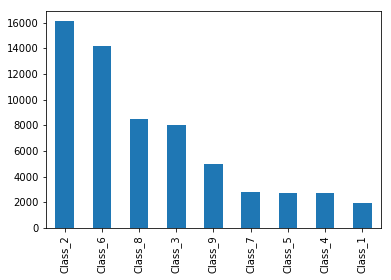

In [8]:
print('the value counts of the target are:')
print(tr_data.iloc[:,-1].value_counts())
print(tr_data.iloc[:,-1].value_counts().plot(kind = 'bar'))

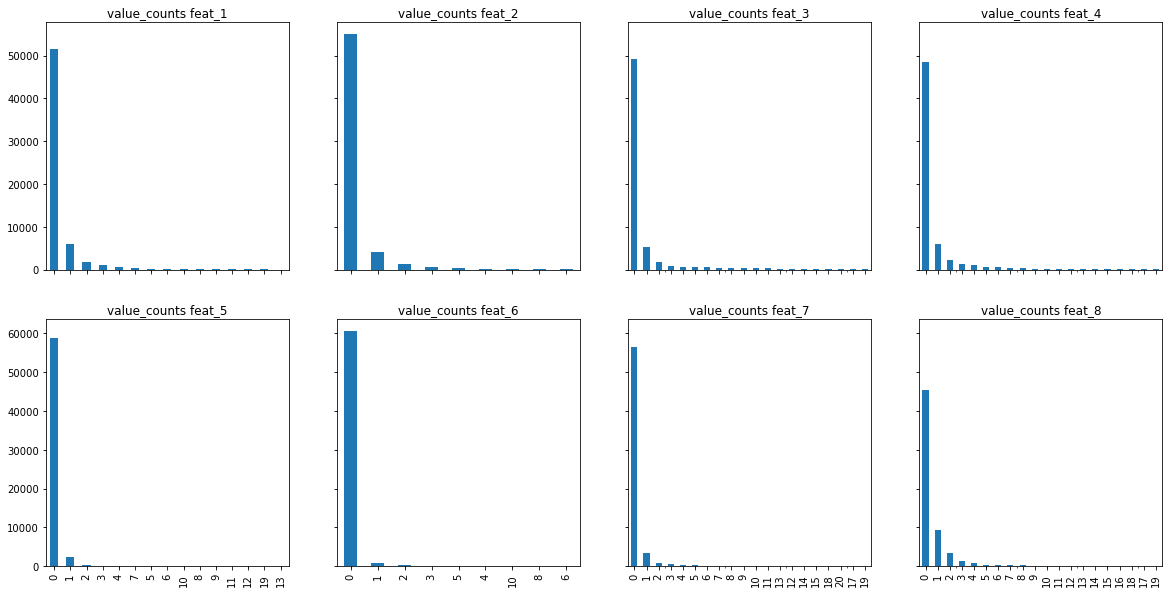

In [9]:
def value_counts_plots(dat,rows = 4, cols = 4):
    _,ax = plt.subplots(rows,cols,sharey='row',sharex='col',figsize = (cols*5,rows*5))
    for i,feat in enumerate(dat.columns[:(rows*cols)]):
        dat[feat].value_counts().iloc[:20].plot(kind = 'bar',ax=ax[int(i/cols), int(i%cols)],title='value_counts {}'.format(feat))

value_counts_plots(tr_data.iloc[:,1:9],2,4)


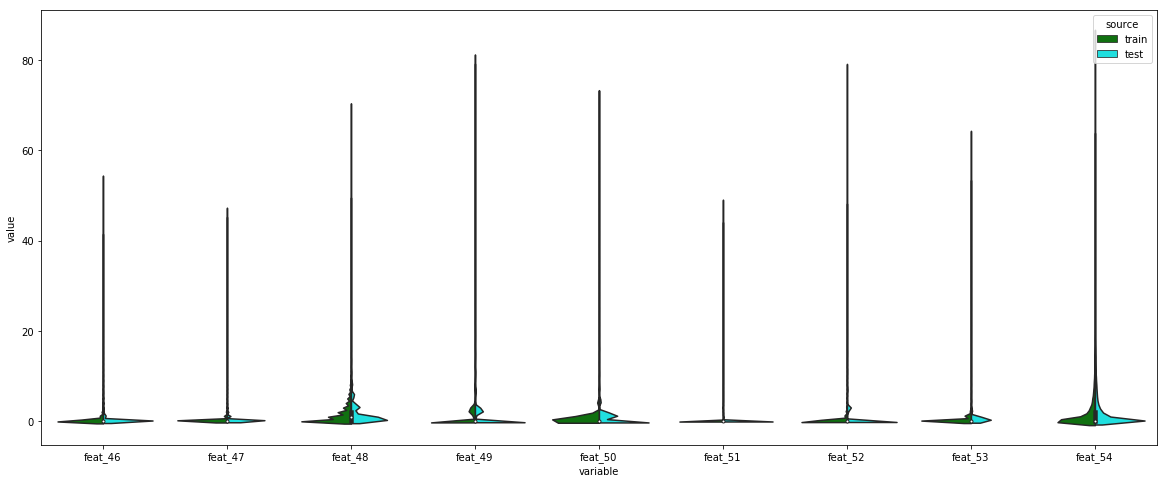

In [10]:
tr_data['source'] = 'train'
te_data['source'] = 'test'
all_data = pd.concat([tr_data,te_data],axis=0)
tr_data.drop('source',axis=1,inplace=True)
te_data.drop('source',axis=1,inplace=True)

molten = pd.melt(all_data, id_vars = 'source',value_vars = ['feat_'+str(x) for x in range(46,55)])
plt.subplots(figsize = (20,8))
sns.violinplot(data=molten, x= 'variable',y='value',hue='source',split = True,palette=my_color_map)

In [11]:
from sklearn.model_selection import train_test_split
tr_data['parsed_target'] = [int(n.split('_')[1]) for n in tr_data.target]
tr_data.drop('target',axis=1,inplace=True)
X_train, X_val, y_train, y_val = train_test_split(tr_data.iloc[:,1:-1],tr_data.parsed_target,test_size = 0.2,random_state =12345)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_jobs=8,n_neighbors=4)
knn.fit(X_train,y_train)
knn2_pred = knn.predict(X_val)

[[ 247   20    3    2    3   20    9   34   72]
 [   5 2723  413   47    6    4   15    5    4]
 [   1  817  663   41    1    1   21    4    1]
 [   3  225  126  169    8   11   13    1    1]
 [   1   11    3    0  520    0    0    0    0]
 [  34   29    7    6    2 2652   32   28   20]
 [  31   80   55   10    4   37  300   18    3]
 [  51   21    8    0    2   60   24 1496   33]
 [  71   27    6    2    4   32    2   36  879]]


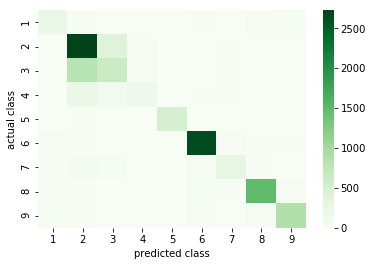

In [13]:
print(confusion_matrix(y_pred=knn2_pred,y_true=y_val))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),
            data = confusion_matrix(y_pred=knn2_pred,y_true=y_val),cmap='Greens')
plt.xlabel('predicted class')
plt.ylabel('actual class')

In [14]:
from sklearn.metrics import classification_report
print('classification report results:\r\n' + classification_report(y_pred=knn2_pred,y_true=y_val))

classification report results:
             precision    recall  f1-score   support

          1       0.56      0.60      0.58       410
          2       0.69      0.85      0.76      3222
          3       0.52      0.43      0.47      1550
          4       0.61      0.30      0.41       557
          5       0.95      0.97      0.96       535
          6       0.94      0.94      0.94      2810
          7       0.72      0.56      0.63       538
          8       0.92      0.88      0.90      1695
          9       0.87      0.83      0.85      1059

avg / total       0.78      0.78      0.77     12376



### Decision Tree

[[ 172   20    6    4    2   43   23   56   84]
 [  20 2304  620  137   10   26   55   27   23]
 [  11  597  748   93    0   12   57   22   10]
 [   5  142  101  244    7   24   20    8    6]
 [   2    8    4    6  508    1    2    1    3]
 [  37   36   13   27    1 2518   63   55   60]
 [  32   61   54   21    4   41  263   41   21]
 [  69   40   26    7    8   94   53 1336   62]
 [  81   29   17   11    4   50   22   69  776]]
classification report results:
             precision    recall  f1-score   support

          1       0.40      0.42      0.41       410
          2       0.71      0.72      0.71      3222
          3       0.47      0.48      0.48      1550
          4       0.44      0.44      0.44       557
          5       0.93      0.95      0.94       535
          6       0.90      0.90      0.90      2810
          7       0.47      0.49      0.48       538
          8       0.83      0.79      0.81      1695
          9       0.74      0.73      0.74      1059

avg 

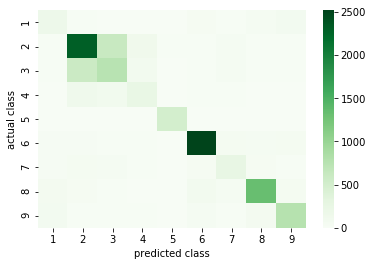

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=100,max_features=92,min_samples_split=2,random_state=12345)
dtc.fit(X_train,y_train)
tree_pred = dtc.predict(X_val)
print(confusion_matrix(y_pred=tree_pred,y_true=y_val))
sns.heatmap(confusion_matrix(y_pred=tree_pred,y_true=y_val),cmap='Greens',xticklabels=range(1,10),yticklabels=range(1,10))
plt.xlabel('predicted class')
plt.ylabel('actual class')
print('classification report results:\r\n' + classification_report(y_pred=tree_pred,y_true=y_val))

[[ 166   15    4    0    0   41    5   82   97]
 [   1 2855  327    6    4    7   12    5    5]
 [   0  750  755   22    0    1   14    7    1]
 [   1  209   72  240    3   22    8    2    0]
 [   0   11    0    0  521    1    0    1    1]
 [   3   29    3    2    0 2699   26   34   14]
 [   4   73   46    6    2   42  315   45    5]
 [  15   13    3    0    1   58    6 1577   22]
 [  24   26    3    0    2   29    3   40  932]]
classification report results:
             precision    recall  f1-score   support

          1       0.78      0.40      0.53       410
          2       0.72      0.89      0.79      3222
          3       0.62      0.49      0.55      1550
          4       0.87      0.43      0.58       557
          5       0.98      0.97      0.98       535
          6       0.93      0.96      0.95      2810
          7       0.81      0.59      0.68       538
          8       0.88      0.93      0.90      1695
          9       0.87      0.88      0.87      1059

avg 

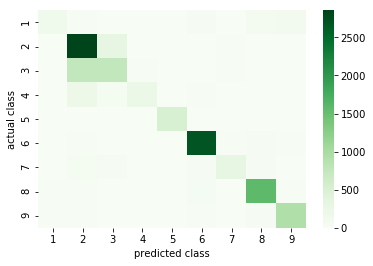

In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=4,n_estimators=100)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_val)
print(confusion_matrix(y_pred=rfc_pred,y_true=y_val))
sns.heatmap(confusion_matrix(y_pred=rfc_pred,y_true=y_val),cmap='Greens',xticklabels=range(1,10),yticklabels=range(1,10))
plt.xlabel('predicted class')
plt.ylabel('actual class')
print('classification report results:\r\n' + classification_report(y_pred=rfc_pred,y_true=y_val))

[[   0    0    0    0    0    0    0    0    0    0]
 [ 208   12    3    0    1   30   11   58   87    0]
 [   3 2779  373   25    8    4   16    9    5    0]
 [   0  674  811   19    0    2   33    7    4    0]
 [   1  164   80  274    5   16   13    3    1    0]
 [   0    7    5    0  523    0    0    0    0    0]
 [  11   20    3    6    0 2689   29   31   21    0]
 [   8   63   37    6    0   31  375   17    1    0]
 [  23    9    6    0    2   44   15 1576   20    0]
 [  36   22    1    1    0   27    6   32  934    0]]
classification report results:
             precision    recall  f1-score   support

          1       0.72      0.51      0.59       410
          2       0.74      0.86      0.80      3222
          3       0.61      0.52      0.57      1550
          4       0.83      0.49      0.62       557
          5       0.97      0.98      0.97       535
          6       0.95      0.96      0.95      2810
          7       0.75      0.70      0.72       538
          8  

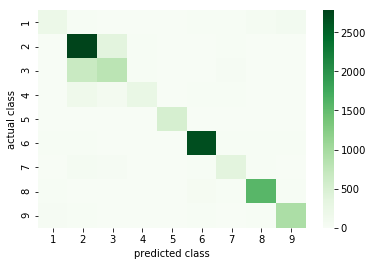

In [17]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=X_train,label=y_train-1) #xgb classes starts from zero
dval = xgb.DMatrix(data=X_val,label=y_val-1) #xgb classes starts from zero
watchlist = [(dval,'eval'), (dtrain,'train')]

xgb_params = {
    'eta': 0.05,
    'max_depth': 7,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.7,
    'alpha':0.1,
    #'objective': 'binary:logistic',
    'objective': 'multi:softmax',
    #'eval_metric': 'auc',
    'eval_metric': 'mlogloss',
    'watchlist':watchlist,
    'print_every_n':5,
    'min_child_weight':2,
    'num_class' : 9
}

bst = xgb.train(params=xgb_params,dtrain=dtrain,num_boost_round=400)
xgb_pred = bst.predict(dval)
print(confusion_matrix(y_pred=xgb_pred,y_true=y_val))
sns.heatmap(confusion_matrix(y_pred=xgb_pred+1,y_true=y_val),cmap='Greens',xticklabels=range(1,10),yticklabels=range(1,10))
plt.xlabel('predicted class')
plt.ylabel('actual class')
print('classification report results:\r\n' + classification_report(y_pred=xgb_pred+1,y_true=y_val))

In [18]:
test_predtest_pre  = bst.predict(xgb.DMatrix(te_data.iloc[:,1:]))

### KNN classifier

In [31]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

np.set_printoptions(precision=2)

# fruits = pd.read_table('fruit_data_with_colors.txt')

# feature_names_fruits = ['height', 'width', 'mass', 'color_score']
# X_fruits = fruits[feature_names_fruits]
# y_fruits = fruits['fruit_label']
# target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

# X_fruits_2d = fruits[['height', 'width']]
# y_fruits_2d = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(tr_data.iloc[:,1:-1],tr_data.parsed_target,test_size = 0.2,random_state =12345)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

example_fruit = [[5.5, 2.2, 10, 0.70]]
example_fruit_scaled = scaler.transform(example_fruit)
print('Predicted fruit type for ', example_fruit, ' is ', 
          target_names_fruits[knn.predict(example_fruit_scaled)[0]-1])


KeyboardInterrupt: 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state=0)

plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, 'uniform', X_test, y_test)

NameError: name 'X_C2' is not defined

In [ ]:
#KNN regressor

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

In [ ]:
# plot k-NN regression on sample dataset for different values of K
fig, subaxes = plt.subplots(5, 1, figsize=(5,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3, 7, 15, 55]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    thisaxis.plot(X_predict_input, y_predict_output)
    thisaxis.plot(X_train, y_train, 'o', alpha=0.9, label='Train')
    thisaxis.plot(X_test, y_test, '^', alpha=0.9, label='Test')
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN Regression (K={})\n\
Train $R^2 = {:.3f}$,  Test $R^2 = {:.3f}$'
                      .format(K, train_score, test_score))
    thisaxis.legend()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [ ]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

In [22]:
### ridge regression: regression that takes into account normlisation

In [ ]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

In [ ]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

In [ ]:
rint('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

In [ ]:
### lasso regression, remove unnecessary features.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Crime dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

In [ ]:
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

### logistical regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import (
plot_class_regions_for_classifier_subplot)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
y_fruits_apple = y_fruits_2d == 1   # make into a binary problem: apples vs everything else
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.as_matrix(),
                y_fruits_apple.as_matrix(),
                random_state = 0))

clf = LogisticRegression(C=100).fit(X_train, y_train)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None,
                                         None, 'Logistic regression \
for binary classification\nFruit dataset: Apple vs others',
                                         subaxes)

h = 6
w = 8
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][clf.predict([[h,w]])[0]]))

h = 10
w = 7
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][clf.predict([[h,w]])[0]]))
subaxes.set_xlabel('height')
subaxes.set_ylabel('width')

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [ ]:
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import (
plot_class_regions_for_classifier_subplot)


X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
clf = LogisticRegression().fit(X_train, y_train)
title = 'Logistic regression, simple synthetic dataset C = {:.3f}'.format(1.0)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                         None, None, title, subaxes)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
     

In [ ]:
# he larger λ is the less likely it is that the parameters will be increased in magnitude simply to adjust for small perturbations in the data. In your case however, rather than specifying λ, you specify C=1/λ.
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.as_matrix(),
                y_fruits_apple.as_matrix(),
                random_state=0))

fig, subaxes = plt.subplots(3, 1, figsize=(4, 10))

for this_C, subplot in zip([0.1, 1, 100], subaxes):
    clf = LogisticRegression(C=this_C).fit(X_train, y_train)
    title ='Logistic regression (apple vs rest), C = {:.3f}'.format(this_C)
    
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             X_test, y_test, title,
                                             subplot)
plt.tight_layout()


In [ ]:
### Support vector machine

### SVM model

TypeError: unhashable type: 'slice'

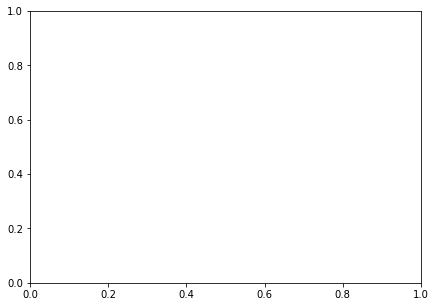

In [26]:
from sklearn.svm import SVC


X_train, X_val, y_train, y_val = train_test_split(tr_data.iloc[:,1:-1],tr_data.parsed_target,test_size = 0.2,random_state =12345)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
this_C = 1.0
clf = SVC(kernel = 'linear', C=this_C).fit(X_train, y_train)
title = 'Linear SVC, C = {:.3f}'.format(this_C)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None, None, title, subaxes)

In [ ]:
from sklearn.svm import LinearSVC
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state = 0)
fig, subaxes = plt.subplots(1, 2, figsize=(8, 4))

for this_C, subplot in zip([0.00001, 100], subaxes):
    clf = LinearSVC(C=this_C).fit(X_train, y_train)
    title = 'Linear SVC, C = {:.5f}'.format(this_C)
    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             None, None, title, subplot)
plt.tight_layout()

### Multi class SVM

In [ ]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

clf = LinearSVC(C=5, random_state = 67).fit(X_train, y_train)
print('Coefficients:\n', clf.coef_)
print('Intercepts:\n', clf.intercept_)

In [ ]:
plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_fruits = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X_fruits_2d[['height']], X_fruits_2d[['width']],
           c=y_fruits_2d, cmap=cmap_fruits, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(-10, 15)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    # Since class prediction with a linear model uses the formula y = w_0 x_0 + w_1 x_1 + b, 
    # and the decision boundary is defined as being all points with y = 0, to plot x_1 as a 
    # function of x_0 we just solve w_0 x_0 + w_1 x_1 + b = 0 for x_1:
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.8)
    
plt.legend(target_names_fruits)
plt.xlabel('height')
plt.ylabel('width')
plt.xlim(-2, 12)
plt.ylim(-2, 15)
plt.show()

In [ ]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)

# The default SVC kernel is radial basis function (RBF)
plot_class_regions_for_classifier(SVC().fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'Support Vector Classifier: RBF kernel')

# Compare decision boundries with polynomial kernel, degree = 3
plot_class_regions_for_classifier(SVC(kernel = 'poly', degree = 3)
                                 .fit(X_train, y_train), X_train,
                                 y_train, None, None,
                                 'Support Vector Classifier: Polynomial kernel, degree = 3')

### Support Vector Machine with RBF kernel: using both C and gamma parameter¶

In [ ]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):
    
    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(this_gamma, this_C)
        clf = SVC(kernel = 'rbf', gamma = this_gamma,
                 C = this_C).fit(X_train, y_train)
        plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                                 X_test, y_test, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#### validation curve

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

### Decision Tree 

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.model_selection import train_test_split


iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 3)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [ ]:
# setting the max depth to prevent overfitting
clf2 = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test, y_test)))

In [ ]:
#Visualisation of decision tree.

In [ ]:
plot_decision_tree(clf, iris.feature_names, iris.target_names)

In [ ]:
#Extracting feature importances

In [ ]:
from adspy_shared_utilities import plot_feature_importances

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, iris.feature_names)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

### Sanity check: Dummy classifier.

In [ ]:
from sklearn.metrics import confusion_matrix

# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_majority_predicted = dummy_majority.predict(X_test)
confusion = confusion_matrix(y_test, y_majority_predicted)

print('Most frequent class (dummy classifier)\n', confusion)

# produces random predictions w/ same class proportion as training set
dummy_classprop = DummyClassifier(strategy='stratified').fit(X_train, y_train)
y_classprop_predicted = dummy_classprop.predict(X_test)
confusion = confusion_matrix(y_test, y_classprop_predicted)

print('Random class-proportional prediction (dummy classifier)\n', confusion)

svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted)

print('Support vector machine classifier (linear kernel, C=1)\n', confusion)

### For evaluation of binary classification

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predicted)))

In [ ]:
# Combined report with all above metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, tree_predicted, target_names=['not 1', '1']))

### Decision function, predict probability

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)
y_scores_lr = lr.fit(X_train, y_train).decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_lr[0:20]))

# show the decision_function scores for first 20 instances
y_score_list

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)
y_proba_lr = lr.fit(X_train, y_train).predict_proba(X_test)
y_proba_list = list(zip(y_test[0:20], y_proba_lr[0:20,1]))

# show the probability of positive class for first 20 instances
y_proba_list

### precision-recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

### ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [ ]:
from matplotlib import cm

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.01, 0.1, 0.20, 1]:
    svm = SVC(gamma=g).fit(X_train, y_train)
    y_score_svm = svm.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = svm.score(X_test, y_test)
    print("gamma = {:.2f}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy_svm, 
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7, 
             label='SVM (gamma = {:0.2f}, area = {:0.2f})'.format(g, roc_auc_svm))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: (1-of-10 digits classifier)', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

### multiple class classification

In [ ]:
dataset = load_digits()
X, y = dataset.data, dataset.target
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X, y, random_state=0)


svm = SVC(kernel = 'linear').fit(X_train_mc, y_train_mc)
svm_predicted_mc = svm.predict(X_test_mc)
confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,10)], columns = [i for i in range(0,10)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_mc, 
                                                                       svm_predicted_mc)))
plt.ylabel('True label')
plt.xlabel('Predicted label')


svm = SVC(kernel = 'rbf').fit(X_train_mc, y_train_mc)
svm_predicted_mc = svm.predict(X_test_mc)
confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
df_cm = pd.DataFrame(confusion_mc, index = [i for i in range(0,10)],
                  columns = [i for i in range(0,10)])

plt.figure(figsize = (5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_mc, 
                                                                    svm_predicted_mc)))
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test_mc, svm_predicted_mc))

### Regression evaluation metrics

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

diabetes = datasets.load_diabetes()

X = diabetes.data[:, None, 6]
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_predict, color='green', linewidth=2)
plt.plot(X_test, y_predict_dummy_mean, color='red', linestyle = 'dashed', 
         linewidth=2, label = 'dummy')

plt.show()

### Cross-validation example¶

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

dataset = load_digits()
# again, making this a binary problem with 'digit 1' as positive class 
# and 'not 1' as negative class
X, y = dataset.data, dataset.target == 1
clf = SVC(kernel='linear', C=1)

# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall'))

### Naive bayes classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1')

### Random forest algo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

### gradient boosting tree

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier().fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('GBDT, Fruit dataset, default settings')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

# X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = AdaBoostClassifier().fit(X_train, y_train)
clf.predict(X_test, y_test)

## Neural Network

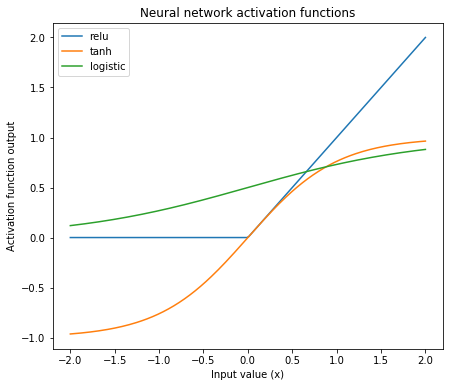

In [28]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### single hidden layer

In [ ]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for units, axis in zip([1, 10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### two hidden layers¶

In [ ]:
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

nnclf = MLPClassifier(hidden_layer_sizes = [10, 10], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)

plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

#### The effect of different choices of activation function

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip(['logistic', 'tanh', 'relu'], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = this_activation,
                         alpha = 0.1, hidden_layer_sizes = [10, 10],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

## NN in real world data 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))